A corriger dans le process etl
- format datime : soit formart UTC soit format ns
- renommer les deux colonnes en df_transport = df_transport.rename(columns={'datetime_rounded': 'timestamp_rounded'})

In [92]:
import pandas as pd
import requests
import json
import os
import io
from dotenv import load_dotenv
import logging
from sqlalchemy import create_engine, text
from xgboost import XGBClassifier
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    roc_auc_score,
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    f1_score,
    precision_score,
    recall_score,
    root_mean_squared_error
)
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

load_dotenv()

True

In [93]:
db_url = os.getenv("DATABASE_URL")

In [94]:
engine = create_engine(
    db_url,
    pool_pre_ping=True,
)

with engine.connect() as conn:
    result_transport = conn.execute(text("SELECT * FROM stg_transport_archive"))
    transport_data = result_transport.mappings().all()  # liste de dictionnaires

    result_weather = conn.execute(text("SELECT * FROM stg_weather_archive"))
    weather_data = result_weather.mappings().all()  # liste de dictionnaires

    

In [95]:
"""BASE_DIR = os.getcwd() 

DATA_DIR = os.path.join(BASE_DIR, "..","data")
json_path = os.path.join(DATA_DIR, "transport_koda_one_bus_3_days.json")
#json_path = os.path.join(DATA_DIR, "transport_koda_one_bus_any_days.json")

if not os.path.exists(json_path):
    print(f"Dossier actuel de recherche : {BASE_DIR}")
    raise FileNotFoundError(f"Le fichier {json_path} est introuvable.")

with open(json_path, 'r', encoding='utf-8') as f:
    transport_data = json.load(f)"""

'BASE_DIR = os.getcwd() \n\nDATA_DIR = os.path.join(BASE_DIR, "..","data")\njson_path = os.path.join(DATA_DIR, "transport_koda_one_bus_3_days.json")\n#json_path = os.path.join(DATA_DIR, "transport_koda_one_bus_any_days.json")\n\nif not os.path.exists(json_path):\n    print(f"Dossier actuel de recherche : {BASE_DIR}")\n    raise FileNotFoundError(f"Le fichier {json_path} est introuvable.")\n\nwith open(json_path, \'r\', encoding=\'utf-8\') as f:\n    transport_data = json.load(f)'

In [96]:
df_transport = pd.DataFrame(transport_data)
df_transport.describe()

,arrival_delay,departure_delay,direction_id,hour,id,stop_sequence,timestamp_rounded
count,24048.000000,24048.000000,24048.00000,24048.000000,24048.000000,24048.000000,24048
mean,87.018297,98.637392,0.50000,13.551647,16490.500000,18.500000,2025-04-01 05:32:47.964071936
min,-497.000000,-485.000000,0.00000,0.000000,4467.000000,1.000000,2025-01-05 23:00:00
25%,0.000000,0.000000,0.00000,9.000000,10478.750000,9.750000,2025-02-11 18:00:00
50%,65.000000,73.000000,0.50000,14.000000,16490.500000,18.500000,2025-03-25 14:00:00
75%,160.000000,168.000000,1.00000,18.000000,22502.250000,27.250000,2025-05-16 08:00:00
max,3427.000000,3438.000000,1.00000,23.000000,28514.000000,36.000000,2025-07-17 22:00:00
std,156.528721,153.060955,0.50001,5.584123,6942.203973,10.388511,NaN


In [97]:
df_weather = pd.DataFrame(weather_data)
df_weather.sample(20)
df_weather.describe()

,cloud_cover,day_of_week,dew_point_2m,est_jour_ferie,est_weekend,month,neige_fondue,precipitation,rain,risque_gel_neige,...,snowfall,soleil_leve,temperature_2m,timestamp_rounded,vacances_scolaires,weather_code,wind_direction_10m,wind_gusts_10m,wind_speed_10m,year
count,8808.000000,8808.00000,8808.000000,8808.000000,8808.000000,8808.000000,8808.000000,8808.000000,8808.000000,8808.000000,...,8808.000000,8808.000000,8808.000000,8808,8808.000000,8808.000000,8808.000000,8808.000000,8808.000000,8808.000000
mean,65.123978,3.00000,4.444028,0.182561,0.283379,6.495913,0.009310,0.063669,0.057312,0.009764,...,0.004458,0.514986,8.281619,2025-07-03 11:30:00,0.305177,9.264192,211.479337,26.112920,11.708606,2025.005450
min,0.000000,0.00000,-15.900000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,-14.300000,2025-01-01 00:00:00,0.000000,0.000000,0.000000,1.100000,0.000000,2025.000000
25%,18.000000,1.00000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,2.500000,2025-04-02 17:45:00,0.000000,0.000000,156.000000,16.900000,7.400000,2025.000000
50%,95.000000,3.00000,4.500000,0.000000,0.000000,7.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,7.800000,2025-07-03 11:30:00,0.000000,3.000000,226.000000,24.500000,11.000000,2025.000000
75%,100.000000,5.00000,9.200000,0.000000,1.000000,10.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,14.300000,2025-10-03 05:15:00,1.000000,3.000000,278.000000,34.200000,15.500000,2025.000000
max,100.000000,6.00000,18.900000,1.000000,1.000000,12.000000,1.000000,8.400000,8.400000,1.000000,...,2.170000,1.000000,27.900000,2026-01-02 23:00:00,1.000000,75.000000,360.000000,91.400000,42.000000,2026.000000
std,41.391292,1.99329,6.711009,0.386328,0.450664,3.462624,0.096042,0.294477,0.286133,0.098334,...,0.049271,0.499804,7.585211,NaN,0.460509,18.712493,92.848273,12.278788,5.791210,0.073624


In [98]:
df_transport = pd.DataFrame(transport_data)

#df_transport = df_transport.rename(columns={'datetime_rounded': 'timestamp_rounded'})

# Pour vérifier
print(df_transport.columns)
df_transport.describe(include='all')

Index(['arrival_delay', 'bus_nbr', 'departure_delay', 'direction_id', 'hour',
       'id', 'stop_sequence', 'timestamp_rounded'],
      dtype='object')


,arrival_delay,bus_nbr,departure_delay,direction_id,hour,id,stop_sequence,timestamp_rounded
count,24048.000000,24048,24048.000000,24048.00000,24048.000000,24048.000000,24048.000000,24048
unique,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,541,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,24048,NaN,NaN,NaN,NaN,NaN,NaN
mean,87.018297,NaN,98.637392,0.50000,13.551647,16490.500000,18.500000,2025-04-01 05:32:47.964071936
min,-497.000000,NaN,-485.000000,0.00000,0.000000,4467.000000,1.000000,2025-01-05 23:00:00
25%,0.000000,NaN,0.000000,0.00000,9.000000,10478.750000,9.750000,2025-02-11 18:00:00
50%,65.000000,NaN,73.000000,0.50000,14.000000,16490.500000,18.500000,2025-03-25 14:00:00
75%,160.000000,NaN,168.000000,1.00000,18.000000,22502.250000,27.250000,2025-05-16 08:00:00
max,3427.000000,NaN,3438.000000,1.00000,23.000000,28514.000000,36.000000,2025-07-17 22:00:00


In [99]:
# 1. Convertir en datetime ET forcer l'UTC pour les deux --> à corriger dans le process etl /!\
#df_transport['timestamp_rounded'] = pd.to_datetime(df_transport['timestamp_rounded'], utc=True)
#df_weather['timestamp_rounded'] = pd.to_datetime(df_weather['timestamp_rounded'], utc=True)

# 2. Maintenant le merge fonctionnera sans erreur
df_merged = pd.merge(
    df_transport,
    df_weather,
    on="timestamp_rounded",
    how="left"
)

# 3. Suppression des colonnes
cols_to_drop = ["id", "observation_uuid", "entity_id", "route_id_static", "timestamp", "timestamp_dt", 
                "trip_id", "route_id", "year", "uv_index", "shortwave_radiation"]

df_merged = df_merged.drop(columns=cols_to_drop, errors='ignore')

df_merged.sample(20)

,arrival_delay,bus_nbr,departure_delay,direction_id,hour,stop_sequence,timestamp_rounded,cloud_cover,day_of_week,dew_point_2m,...,risque_gel_neige,risque_gel_pluie,snowfall,soleil_leve,temperature_2m,vacances_scolaires,weather_code,wind_direction_10m,wind_gusts_10m,wind_speed_10m
13898,21,541,34,1,5,31,2025-04-07 05:00:00,100,0,-0.1,...,0,0,0.00,1,4.0,1,3,349,20.5,10.6
8304,-69,541,-63,0,9,19,2025-02-27 09:00:00,100,3,2.0,...,0,0,0.00,1,2.0,1,3,141,14.0,7.2
21845,-1,541,-1,1,22,34,2025-06-19 22:00:00,9,3,7.1,...,0,0,0.00,0,14.5,1,0,314,22.3,11.2
3912,-83,541,-65,0,15,18,2025-02-04 15:00:00,100,1,-0.2,...,0,0,0.00,1,0.9,0,3,191,19.8,8.4
7448,-88,541,-88,1,8,22,2025-02-21 08:00:00,100,4,-1.2,...,0,0,0.35,1,0.4,0,73,200,49.3,23.1
17901,-54,541,-51,1,9,9,2025-05-15 09:00:00,73,3,2.7,...,0,0,0.00,1,10.4,0,2,8,67.0,25.8
108,253,541,259,0,15,14,2025-01-06 15:00:00,100,0,-2.2,...,0,0,0.07,1,0.1,1,71,105,35.6,16.8
7610,-90,541,-88,0,8,27,2025-02-22 08:00:00,100,5,2.0,...,0,0,0.00,1,2.4,0,3,190,25.2,12.1
16536,39,541,39,1,23,5,2025-05-02 23:00:00,0,4,3.0,...,0,0,0.00,0,9.4,0,0,270,33.1,15.1
16477,76,541,85,0,22,4,2025-05-02 22:00:00,0,4,3.1,...,0,0,0.00,0,9.8,0,0,262,31.3,15.6


In [100]:
df_merged.columns

Index(['arrival_delay', 'bus_nbr', 'departure_delay', 'direction_id', 'hour',
       'stop_sequence', 'timestamp_rounded', 'cloud_cover', 'day_of_week',
       'dew_point_2m', 'est_jour_ferie', 'est_weekend', 'month',
       'neige_fondue', 'precipitation', 'rain', 'risque_gel_neige',
       'risque_gel_pluie', 'snowfall', 'soleil_leve', 'temperature_2m',
       'vacances_scolaires', 'weather_code', 'wind_direction_10m',
       'wind_gusts_10m', 'wind_speed_10m'],
      dtype='object')

# EDA

In [101]:
# ====================
# 1. CHARGEMENT ET NETTOYAGE
# ====================

# Filtrer les données avec transport
df = df_merged[df_merged['departure_delay'].notna()].copy()

print("="*20)
print("EXPLORATION DES DONNÉES - JUSTIFICATION MÉTHODOLOGIQUE")
print("="*20)
print(f"\nNombre total d'observations : {len(df):,}")
print(f"Période couverte : {df['timestamp_rounded'].min()} à {df['timestamp_rounded'].max()}")
print(f"Nombre de jours : {df['timestamp_rounded'].dt.date.nunique()}")

EXPLORATION DES DONNÉES - JUSTIFICATION MÉTHODOLOGIQUE

Nombre total d'observations : 24,048
Période couverte : 2025-01-05 23:00:00 à 2025-07-17 22:00:00
Nombre de jours : 164



1. DISTRIBUTION DES RETARDS

Statistiques des retards (en secondes) :
count    24048.000000
mean        98.637392
std        153.060955
min       -485.000000
25%          0.000000
50%         73.000000
75%        168.000000
max       3438.000000
Name: departure_delay, dtype: float64

Médiane : 73.0s
Mode : 0.0s

Répartition par tranches de retard :
delay_category
Avance      6462
0-1 min     4544
1-2 min     4399
2-5 min     6599
5-10 min    1791
>10 min      252
Name: count, dtype: int64

En pourcentage :
delay_category
Avance      26.9
0-1 min     18.9
1-2 min     18.3
2-5 min     27.4
5-10 min     7.4
>10 min      1.0
Name: proportion, dtype: float64


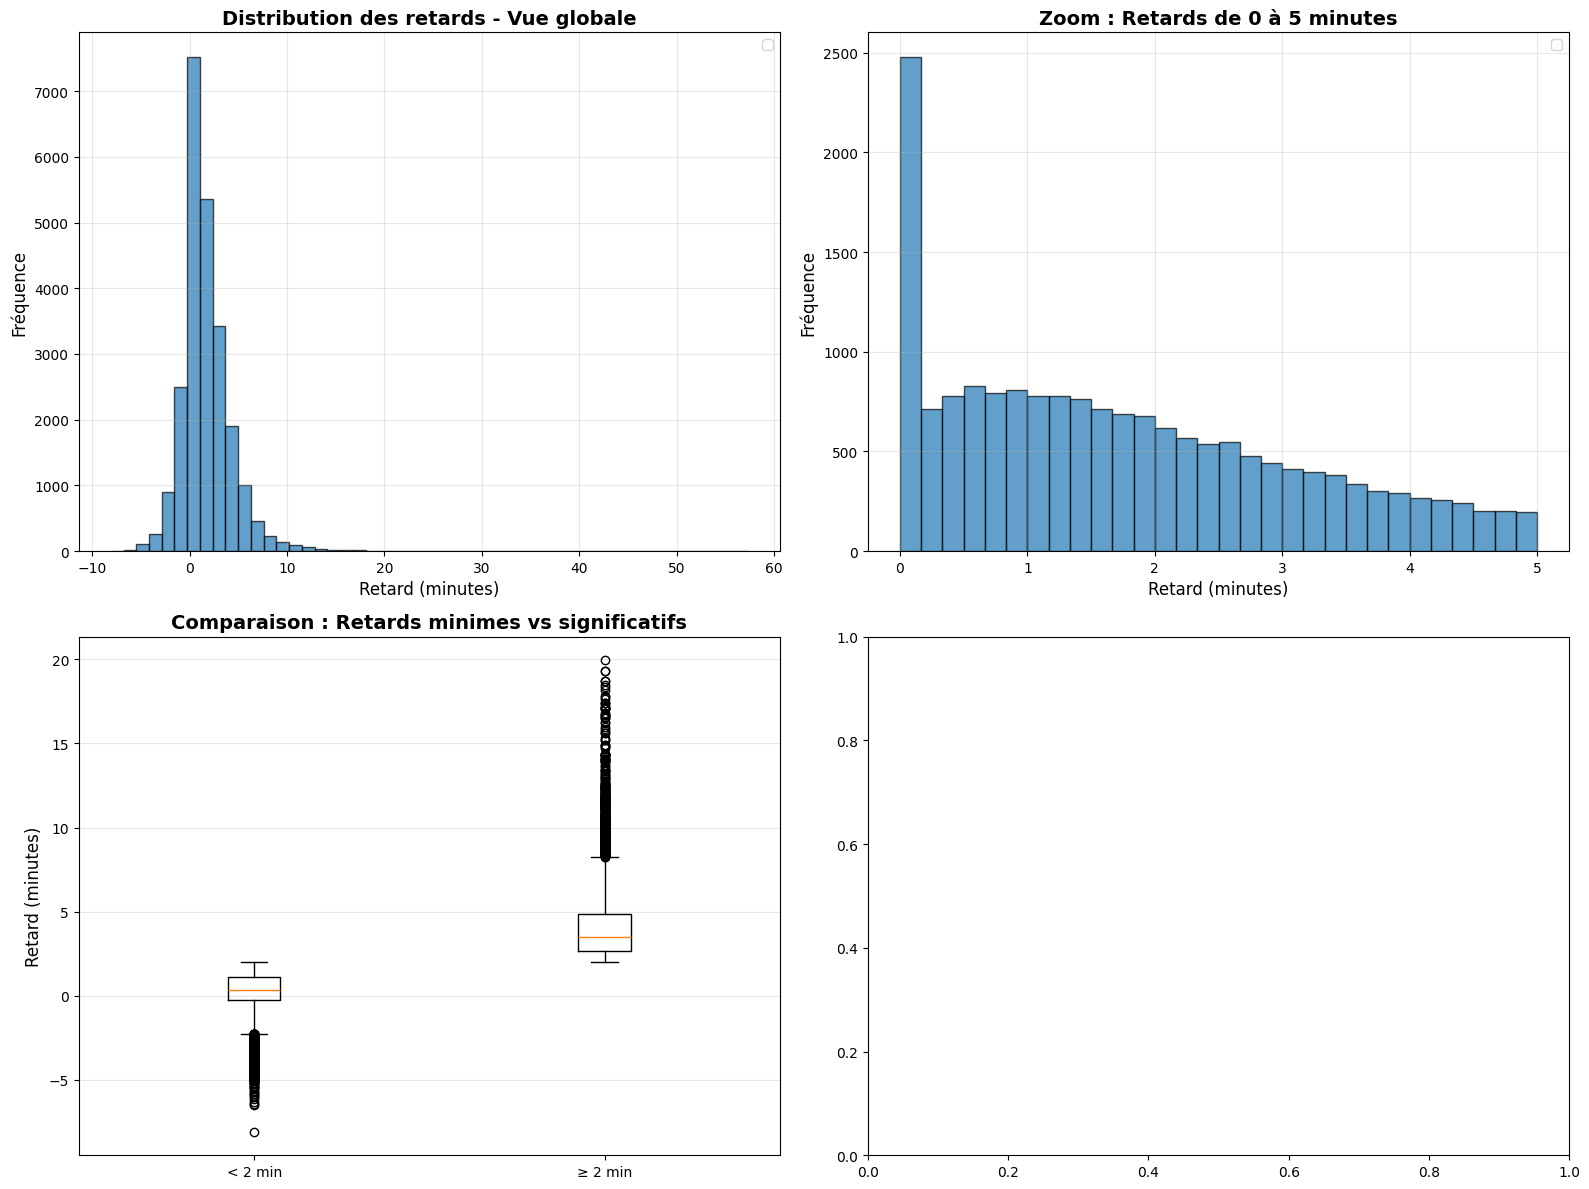

In [102]:
# ====================
# 2. DISTRIBUTION DES RETARDS - ARGUMENT CLÉ
# ====================

print("\n" + "="*20)
print("1. DISTRIBUTION DES RETARDS")
print("="*20)

# Statistiques descriptives
print("\nStatistiques des retards (en secondes) :")
print(df['departure_delay'].describe())
print(f"\nMédiane : {df['departure_delay'].median():.1f}s")
print(f"Mode : {df['departure_delay'].mode().values[0]:.1f}s")

# Conversion en minutes pour lisibilité
df['delay_minutes'] = df['departure_delay'] / 60

# Distribution détaillée par tranches
print("\nRépartition par tranches de retard :")
bins = [-500, 0, 60, 120, 300, 600, 3000]
labels = ['Avance', '0-1 min', '1-2 min', '2-5 min', '5-10 min', '>10 min']
df['delay_category'] = pd.cut(df['departure_delay'], bins=bins, labels=labels)
print(df['delay_category'].value_counts().sort_index())
print("\nEn pourcentage :")
print((df['delay_category'].value_counts(normalize=True)*100).sort_index().round(1))

# GRAPHIQUE 1 : Distribution bimodale
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Histogramme global
axes[0, 0].hist(df['delay_minutes'], bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Retard (minutes)', fontsize=12)
axes[0, 0].set_ylabel('Fréquence', fontsize=12)
axes[0, 0].set_title('Distribution des retards - Vue globale', fontsize=14, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Focus sur les petits retards (0-5 min)
mask_small = (df['delay_minutes'] >= 0) & (df['delay_minutes'] <= 5)
axes[0, 1].hist(df.loc[mask_small, 'delay_minutes'], bins=30, edgecolor='black', alpha=0.7)
axes[0, 1].set_xlabel('Retard (minutes)', fontsize=12)
axes[0, 1].set_ylabel('Fréquence', fontsize=12)
axes[0, 1].set_title('Zoom : Retards de 0 à 5 minutes', fontsize=14, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Boxplot par catégories
df_boxplot = df[df['delay_minutes'] <= 20]  # Limiter pour visibilité
axes[1, 0].boxplot([df_boxplot[df_boxplot['delay_minutes'] < 2]['delay_minutes'],
                     df_boxplot[df_boxplot['delay_minutes'] >= 2]['delay_minutes']],
                    labels=['< 2 min', '≥ 2 min'])
axes[1, 0].set_ylabel('Retard (minutes)', fontsize=12)
axes[1, 0].set_title('Comparaison : Retards minimes vs significatifs', fontsize=14, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3, axis='y')

plt.tight_layout()

Distribution des retards
- la moitié des trajets ont moins de 1 min 15 de retards (médiane)
- la moyenne est plus élevée que la médiane et est tirée vers le haut par quelques gros retards
- le cas le plus fréquent est qu'il y a 0 retards (voir de l'avance dans 26% des cas !)
- Très grande dispersion (153 s ecart-type)

Distribution : asymétrique, queue lourde, beaucoup de masse autour de 0-180 s

Essais sur détermination d'un seuil : 
Dans une logique "métier", on pourrait penser qu'à partir de 2 min , c'est considéré comme du retards.
sauf, que : 
- 46% des observations sont entre 1 et 5 minutes
- un seuil de 120 s est pile au milieu de la zone la plus dense

c'est exactement la situation où les features changents peu, mais le label change "brutalement"

conclusion : 
- si application d'un seuil `is_delayed = (delay > 120s)` sera intrinsèquement bruitée et aucun modèle de classification pourra faire de "bons résultats"
- il n'existe aucun seuil naturel dans les données de retards entre 0 et 5 minutes
- le problème ne se décompose pas en deux tâches
--> un modèle à deux étages serait donc mal posés

"Le seuil de 2 minutes (ou plus ou moins), bien que pertinent d’un point de vue métier, se situe dans une zone de forte densité de la distribution des retards. Cette proximité induit un bruit de labellisation important, limitant mécaniquement les performances de la classification. Les approches continues (régression) se révèlent plus adaptées à la structure réelle des données."




3. CORRÉLATIONS DIFFÉRENTES SELON LE GROUPE

 Corrélations avec departure_delay :
                Sans_retard  Avec_retard  Différence
temperature_2m       -0.013        0.016       0.028
precipitation        -0.000       -0.007      -0.007
wind_speed_10m       -0.015       -0.010       0.005
cloud_cover          -0.031       -0.035      -0.005
stop_sequence        -0.361        0.060       0.421
hour                  0.014        0.136       0.123


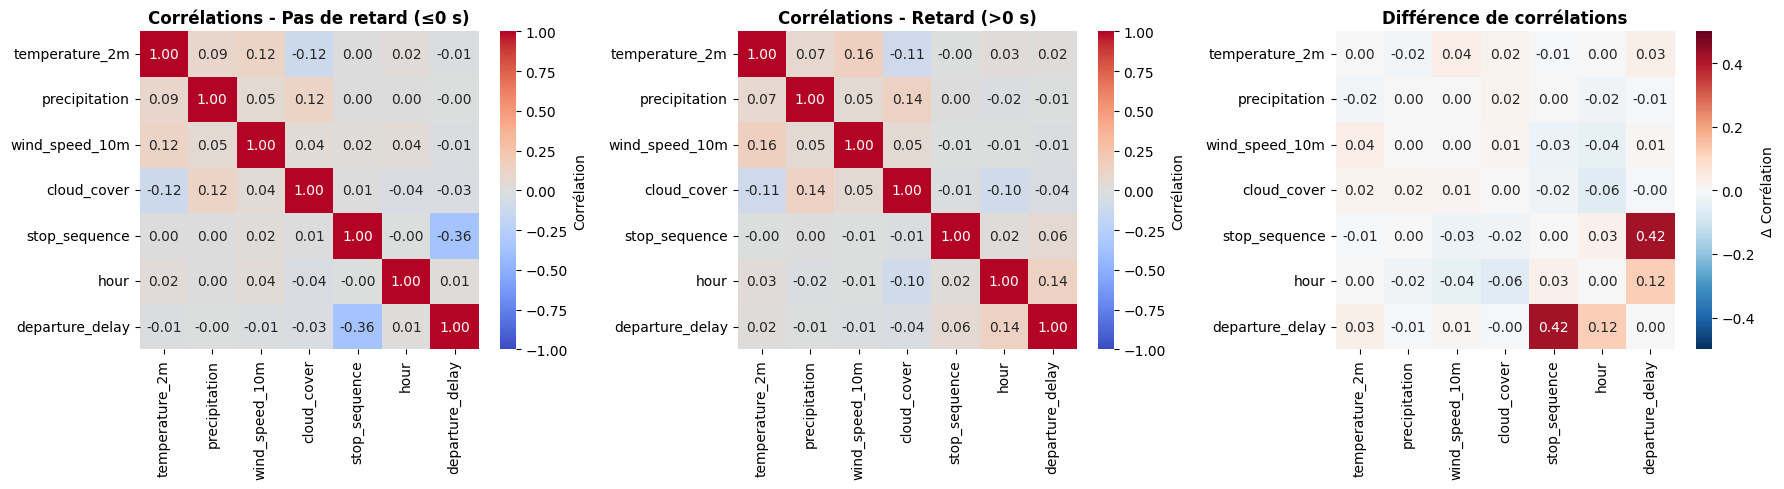

In [103]:
# ============================================================================
# 3. CORRÉLATIONS CONDITIONNELLES
# ============================================================================

print("\n" + "="*20)
print("3. CORRÉLATIONS DIFFÉRENTES SELON LE GROUPE")
print("="*20)

SEUIL = 120  # 2 minutes
df['has_delay'] = (df['departure_delay'] > 0).astype(int)

# Calculer corrélations pour chaque groupe
numeric_cols = ['temperature_2m', 'precipitation', 'wind_speed_10m', 
                'cloud_cover', 'stop_sequence', 'hour']

df_no_delay = df[df['has_delay']==0][numeric_cols + ['departure_delay']].copy()
df_delay = df[df['has_delay']==1][numeric_cols + ['departure_delay']].copy()

corr_no_delay = df_no_delay.corr()['departure_delay'].drop('departure_delay')
corr_delay = df_delay.corr()['departure_delay'].drop('departure_delay')

print("\n Corrélations avec departure_delay :")
corr_comparison = pd.DataFrame({
    'Sans_retard': corr_no_delay,
    'Avec_retard': corr_delay,
    'Différence': corr_delay - corr_no_delay
})
print(corr_comparison.round(3))

# GRAPHIQUE 3 : Heatmap comparative
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Sans retard
sns.heatmap(df_no_delay.corr(), annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, vmin=-1, vmax=1, ax=axes[0], cbar_kws={'label': 'Corrélation'})
axes[0].set_title('Corrélations - Pas de retard (≤0 s)', fontsize=12, fontweight='bold')

# Avec retard
sns.heatmap(df_delay.corr(), annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, vmin=-1, vmax=1, ax=axes[1], cbar_kws={'label': 'Corrélation'})
axes[1].set_title('Corrélations - Retard (>0 s)', fontsize=12, fontweight='bold')

# Différence
diff_matrix = df_delay.corr() - df_no_delay.corr()
sns.heatmap(diff_matrix, annot=True, fmt='.2f', cmap='RdBu_r', 
            center=0, vmin=-0.5, vmax=0.5, ax=axes[2], cbar_kws={'label': 'Δ Corrélation'})
axes[2].set_title('Différence de corrélations', fontsize=12, fontweight='bold')

plt.tight_layout()


4. PATTERNS TEMPORELS - Justification de features temporelles

Retards par heure de la journée :
    hour  prob_retard  retard_moyen
0      0         0.82        130.01
1      1         0.61        128.03
2      3         0.80         77.71
3      4         0.75         72.90
4      5         0.70         60.37
5      6         0.68         60.39
6      7         0.71         76.95
7      8         0.67         68.21
8      9         0.68         61.82
9     10         0.71         75.80
10    11         0.75         99.67
11    12         0.73        106.81
12    13         0.71        101.47
13    14         0.72         97.33
14    15         0.72        103.79
15    16         0.70        106.43
16    17         0.73        107.99
17    18         0.77        127.13
18    19         0.80        137.55
19    20         0.75        109.06
20    21         0.75        106.57
21    22         0.81        131.32
22    23         0.80        135.86


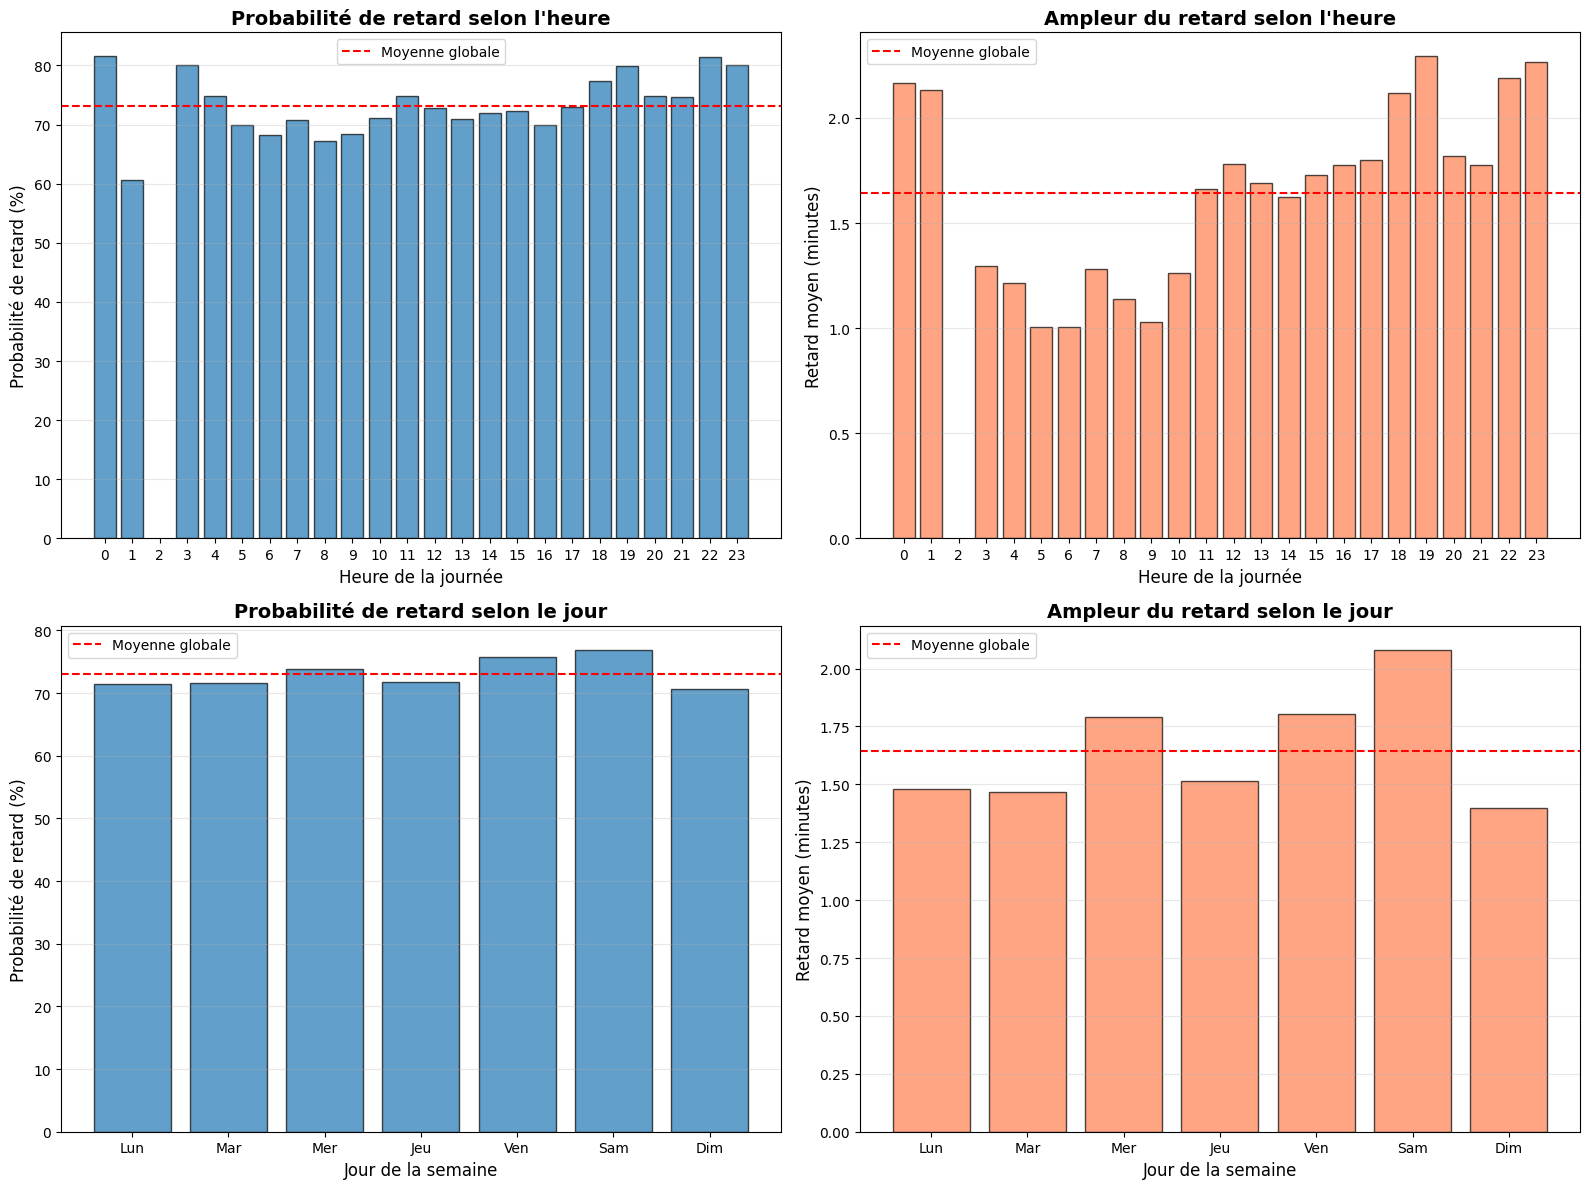

In [104]:
# =====================
# 5. PATTERNS TEMPORELS
# =====================

print("\n" + "="*20)
print("4. PATTERNS TEMPORELS - Justification de features temporelles")
print("="*20)

# Par heure
delay_by_hour = df.groupby('hour').agg({
    'has_delay': 'mean',
    'departure_delay': 'mean'
}).reset_index()
delay_by_hour.columns = ['hour', 'prob_retard', 'retard_moyen']

print("\nRetards par heure de la journée :")
print(delay_by_hour.round(2))

# Par jour de la semaine
delay_by_dow = df.groupby('day_of_week').agg({
    'has_delay': 'mean',
    'departure_delay': 'mean'
}).reset_index()
delay_by_dow.columns = ['day_of_week', 'prob_retard', 'retard_moyen']
delay_by_dow['day_name'] = delay_by_dow['day_of_week'].map({
    0: 'Lun', 1: 'Mar', 2: 'Mer', 3: 'Jeu', 4: 'Ven', 5: 'Sam', 6: 'Dim'
})

# GRAPHIQUE 4 : Patterns temporels
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1- Probabilité de retard par heure
axes[0, 0].bar(delay_by_hour['hour'], delay_by_hour['prob_retard']*100, 
               edgecolor='black', alpha=0.7)
axes[0, 0].axhline(df['has_delay'].mean()*100, color='red', linestyle='--', 
                   label='Moyenne globale')
axes[0, 0].set_xlabel('Heure de la journée', fontsize=12)
axes[0, 0].set_ylabel('Probabilité de retard (%)', fontsize=12)
axes[0, 0].set_title('Probabilité de retard selon l\'heure', fontsize=14, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3, axis='y')
axes[0, 0].set_xticks(range(24))

# 2- Ampleur moyenne par heure
axes[0, 1].bar(delay_by_hour['hour'], delay_by_hour['retard_moyen']/60, 
               color='coral', edgecolor='black', alpha=0.7)
axes[0, 1].axhline(df['departure_delay'].mean()/60, color='red', linestyle='--', 
                   label='Moyenne globale')
axes[0, 1].set_xlabel('Heure de la journée', fontsize=12)
axes[0, 1].set_ylabel('Retard moyen (minutes)', fontsize=12)
axes[0, 1].set_title('Ampleur du retard selon l\'heure', fontsize=14, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3, axis='y')
axes[0, 1].set_xticks(range(24))

# 3- Par jour de la semaine - Probabilité
axes[1, 0].bar(delay_by_dow['day_name'], delay_by_dow['prob_retard']*100, 
               edgecolor='black', alpha=0.7)
axes[1, 0].axhline(df['has_delay'].mean()*100, color='red', linestyle='--', 
                   label='Moyenne globale')
axes[1, 0].set_xlabel('Jour de la semaine', fontsize=12)
axes[1, 0].set_ylabel('Probabilité de retard (%)', fontsize=12)
axes[1, 0].set_title('Probabilité de retard selon le jour', fontsize=14, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3, axis='y')

# 4- Par jour de la semaine - Ampleur
axes[1, 1].bar(delay_by_dow['day_name'], delay_by_dow['retard_moyen']/60, 
               color='coral', edgecolor='black', alpha=0.7)
axes[1, 1].axhline(df['departure_delay'].mean()/60, color='red', linestyle='--', 
                   label='Moyenne globale')
axes[1, 1].set_xlabel('Jour de la semaine', fontsize=12)
axes[1, 1].set_ylabel('Retard moyen (minutes)', fontsize=12)
axes[1, 1].set_title('Ampleur du retard selon le jour', fontsize=14, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()

- `prob_retard` (probabilité d’avoir un retard > 0 s)
- `retard_moyen` (intensité du retard)

- Heures à risque de retards élevé : 0h, 18h-23h --> `prob_retard` = 0.45-0.47 // `retard_moyen` = 125-138s
- Heures 'fluides : 4h-6h --> `prob_retard` = 0.22-0.24 // `retard_moyen` = 60s

Malgré ces écarts : 
- la variation est progressive
- pas d'heure charnières où le système change brutalement


5. IMPACT MÉTÉO - Différent selon qu'il y a retard ou non

 Retards selon les conditions météo :
              Nombre  Prob_retard  Retard_moyen_sec  Retard_moyen_min
weather_code                                                         
Bruine          1937         0.72             89.89          1.498167
Ciel clair      6146         0.75            109.93          1.832167
Neige            473         0.73            103.09          1.718167
Nuageux        15383         0.73             95.26          1.587667
Pluie            109         0.66             73.87          1.231167


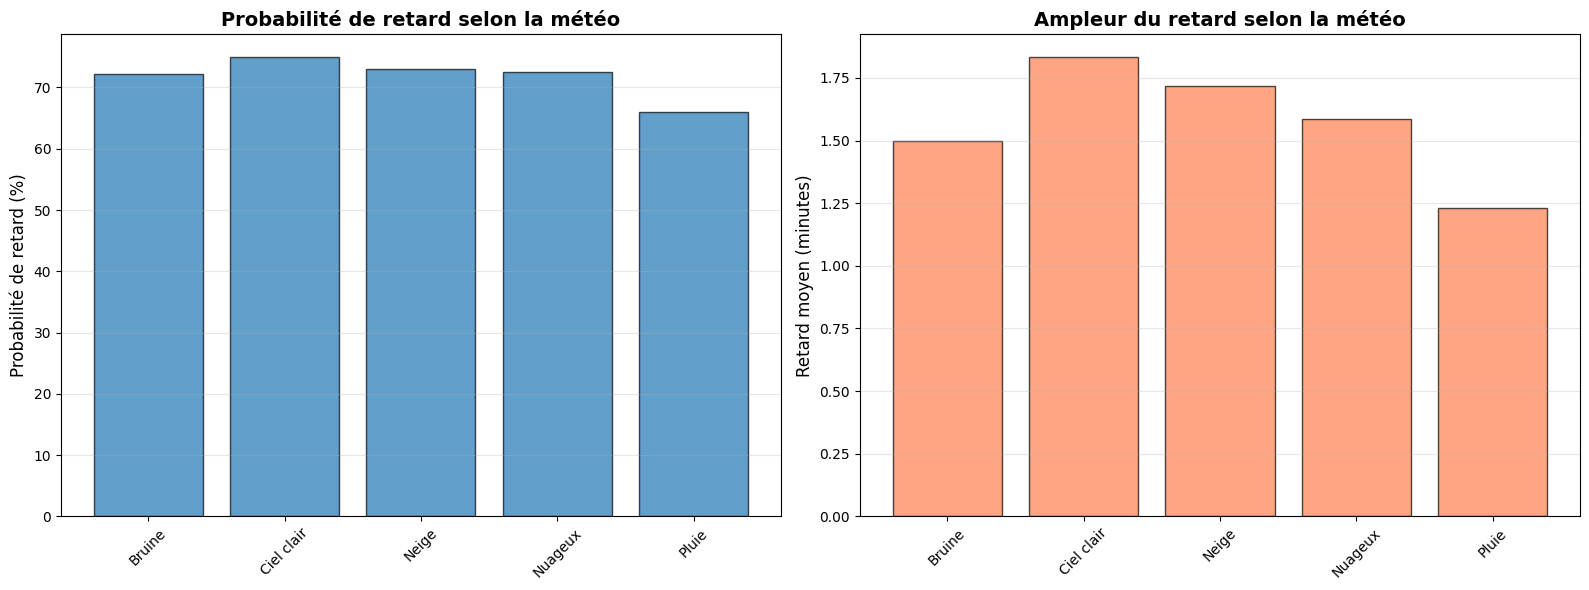

In [105]:
# ========================================
# 6. IMPACT MÉTÉO - VISION CONDITIONNELLE
# =======================================

print("\n" + "="*20)
print("5. IMPACT MÉTÉO - Différent selon qu'il y a retard ou non")
print("="*20)

# Catégoriser la météo
df.loc[df['weather_code'].isin([61, 63, 65]), 'weather_code'] = 'Pluie'
df.loc[df['weather_code'].isin([71, 73, 75]), 'weather_code'] = 'Neige'
df.loc[df['weather_code'].isin([51, 53, 55]), 'weather_code'] = 'Bruine'
df.loc[df['weather_code'].isin([1, 2, 3]), 'weather_code'] = 'Nuageux'
df.loc[df['weather_code'].isin([0]), 'weather_code'] = 'Ciel clair'

print("\n Retards selon les conditions météo :")
meteo_impact = df.groupby('weather_code').agg({
    'has_delay': ['count', 'mean'],
    'departure_delay': 'mean'
}).round(2)

meteo_impact.columns = ['Nombre', 'Prob_retard', 'Retard_moyen_sec']
meteo_impact['Retard_moyen_min'] = meteo_impact['Retard_moyen_sec'] / 60
print(meteo_impact)

# GRAPHIQUE 5 : Impact météo
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

meteo_stats = df.groupby('weather_code').agg({
    'has_delay': 'mean',
    'departure_delay': 'mean'
}).reset_index()

axes[0].bar(meteo_stats['weather_code'], meteo_stats['has_delay']*100, 
            edgecolor='black', alpha=0.7)
axes[0].set_ylabel('Probabilité de retard (%)', fontsize=12)
axes[0].set_title('Probabilité de retard selon la météo', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].tick_params(axis='x', rotation=45)

axes[1].bar(meteo_stats['weather_code'], meteo_stats['departure_delay']/60, 
            color='coral', edgecolor='black', alpha=0.7)
axes[1].set_ylabel('Retard moyen (minutes)', fontsize=12)
axes[1].set_title('Ampleur du retard selon la météo', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()

- la météo a un effet réel mai smodéré
- elle ne crée par d'effet "ctastrophe" (sauf cas extrêmes)

- Différence de 30-40 s max
- Pas de rupture

In [106]:
# Statistiques finales
print("\n Statistiques finales :")
print(f"  Nombre total d'observations : {len(df):}")
print(f"  Retard moyen global : {df['departure_delay'].mean()/60:.2f} minutes")
print(f"  Retard moyen si retard >0 s : {df[df['has_delay']==1]['departure_delay'].mean()/60:.2f} minutes")
print(f"  Écart-type global : {df['departure_delay'].std()/60:.2f} minutes")
print(f"  Écart-type si retard >0 s : {df[df['has_delay']==1]['departure_delay'].std()/60:.2f} minutes")

print("\n" + "="*20)
print("EXPLORATION TERMINÉE")
print("="*20)


 Statistiques finales :
  Nombre total d'observations : 24048
  Retard moyen global : 1.64 minutes
  Retard moyen si retard >0 s : 2.56 minutes
  Écart-type global : 2.55 minutes
  Écart-type si retard >0 s : 2.32 minutes

EXPLORATION TERMINÉE


## Synthèse 

### Synthèse

L'EDA suggère que : 
- le retard est le résultat de micro-perturbations cumulées
- pas d’“événement déclencheur” clair avant 5–10 min
- chaque minute supplémentaire est juste un peu moins probable
- la météo a un effet sur la moyenne mais n'a pas un effet de modification du changement d'état (retard ou pas retard)
- pas d'heure charnières où le système change brutalement
**--> C’est un processus continu, pas un changement d’état.**
**Il n’existe PAS de seuil naturel lié :**
- au retard lui-même,
- à l’heure,
- à la météo.

**Les effets sont :**
- additifs,
- continus,
- cumulatifs.

# Recherche modèle optimal de ML

## Modèle 1 - Classification + régression

- Sans application de seuil
- l'idée étant de répondre 
  - 1/ y a t t il un retard ?
  - 2/ de combien sera le retard ?

In [107]:
# ====================
# PRÉPARATION DES DONNÉES
# ====================
# Filtrer uniquement les lignes où on a des données de transport
df = df_merged[df_merged['departure_delay'].notna()].copy()

print(f"Nombre total d'observations : {len(df)}")
print(f"Retards > 2 min : {(df['departure_delay'] > 120).sum()} ({(df['departure_delay'] > 120).mean()*100:.1f}%)")

Nombre total d'observations : 24048
Retards > 2 min : 8643 (35.9%)


In [108]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24048 entries, 0 to 24047
Data columns (total 26 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   arrival_delay       24048 non-null  int64         
 1   bus_nbr             24048 non-null  object        
 2   departure_delay     24048 non-null  int64         
 3   direction_id        24048 non-null  int64         
 4   hour                24048 non-null  int64         
 5   stop_sequence       24048 non-null  int64         
 6   timestamp_rounded   24048 non-null  datetime64[ns]
 7   cloud_cover         24048 non-null  int64         
 8   day_of_week         24048 non-null  int64         
 9   dew_point_2m        24048 non-null  float64       
 10  est_jour_ferie      24048 non-null  int64         
 11  est_weekend         24048 non-null  int64         
 12  month               24048 non-null  int64         
 13  neige_fondue        24048 non-null  int64     

In [109]:
# ====================
# FEATURE ENGINEERING
# ====================

# Définir le seuil de retard (2 minutes = 120 secondes)
SEUIL_RETARD = 0.1
df['is_delayed'] = (df['departure_delay'] > SEUIL_RETARD).astype(int)

# Features temporelles additionnelles
#df['is_rush_hour'] = df['hour'].isin([7, 8, 9, 17, 18, 19]).astype(int)

# Sélection des features
feature_cols = [
    # Transport
    'direction_id', 'stop_sequence', 'hour', 
    # Temporel
    'day_of_week', 'est_weekend', 'est_jour_ferie', 'vacances_scolaires',
    'is_rush_hour', 'soleil_leve', 'month',
    # Météo brute
    'temperature_2m', 'precipitation', 'wind_speed_10m', 'cloud_cover',
    'snowfall', 'rain', 'weather_code', 'dew_point_2m', 'wind_direction_10m', 'wind_gusts_10m',
    # Risques
    'risque_gel_neige', 'risque_gel_pluie', 'neige_fondue'
]

# Garder seulement les colonnes existantes
feature_cols = [col for col in feature_cols if col in df.columns]

# Séparer features numériques et catégorielles
numeric_features = df[feature_cols].select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = df[feature_cols].select_dtypes(include=['object']).columns.tolist()

print(f"\nFeatures numériques : {len(numeric_features)}")
print(f"Features catégorielles : {len(categorical_features)}")


Features numériques : 22
Features catégorielles : 0


In [110]:
# ====================
# PRÉPARATION X ET Y
# ====================

X = df[feature_cols].copy()
y_classification = df['is_delayed']


# Split train/test
X_train, X_test, y_class_train, y_class_test = train_test_split(
    X, y_classification, test_size=0.2, random_state=42, stratify=y_classification
)

print(f"Train : {X_train.shape[0]} samples ({y_class_train.sum()} retards)")
print(f"Test  : {X_test.shape[0]} samples ({y_class_test.sum()} retards)")

# ====================
# PIPELINE DE PRÉTRAITEMENT
# ====================

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
    ],
    remainder='drop'
)

Train : 19238 samples (14069 retards)
Test  : 4810 samples (3517 retards)



 Entraînement des modèles...

Entraînement LogisticRegression...
F1-Score : 0.8467
Recall   : 0.9497
Precision: 0.7640
Seuil optimal: 0.33

Entraînement RandomForest...
F1-Score : 0.8562
Recall   : 0.9667
Precision: 0.7684
Seuil optimal: 0.31

Entraînement XGBoost...
F1-Score : 0.8590
Recall   : 0.9727
Precision: 0.7691
Seuil optimal: 0.30

RÉSULTATS FINAUX SUR TEST SET
            Modèle  F1-Score   Recall  Precision  Seuil
           XGBoost  0.859008 0.972704   0.769110   0.30
      RandomForest  0.856208 0.966733   0.768362   0.31
LogisticRegression  0.846749 0.949673   0.763952   0.33


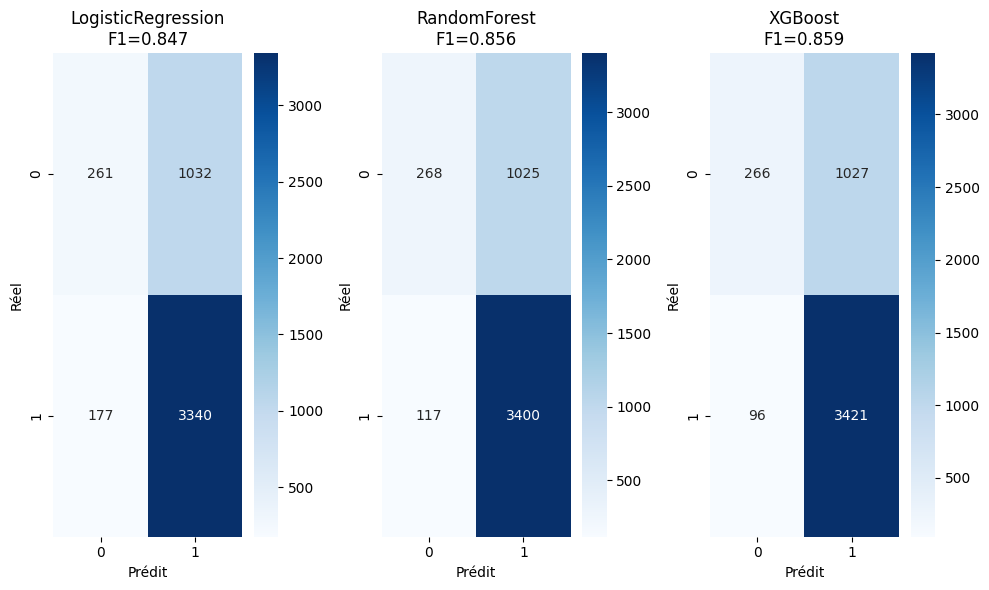


ENTRAÎNEMENT TERMINÉ

Visualisation de l'importance des features...


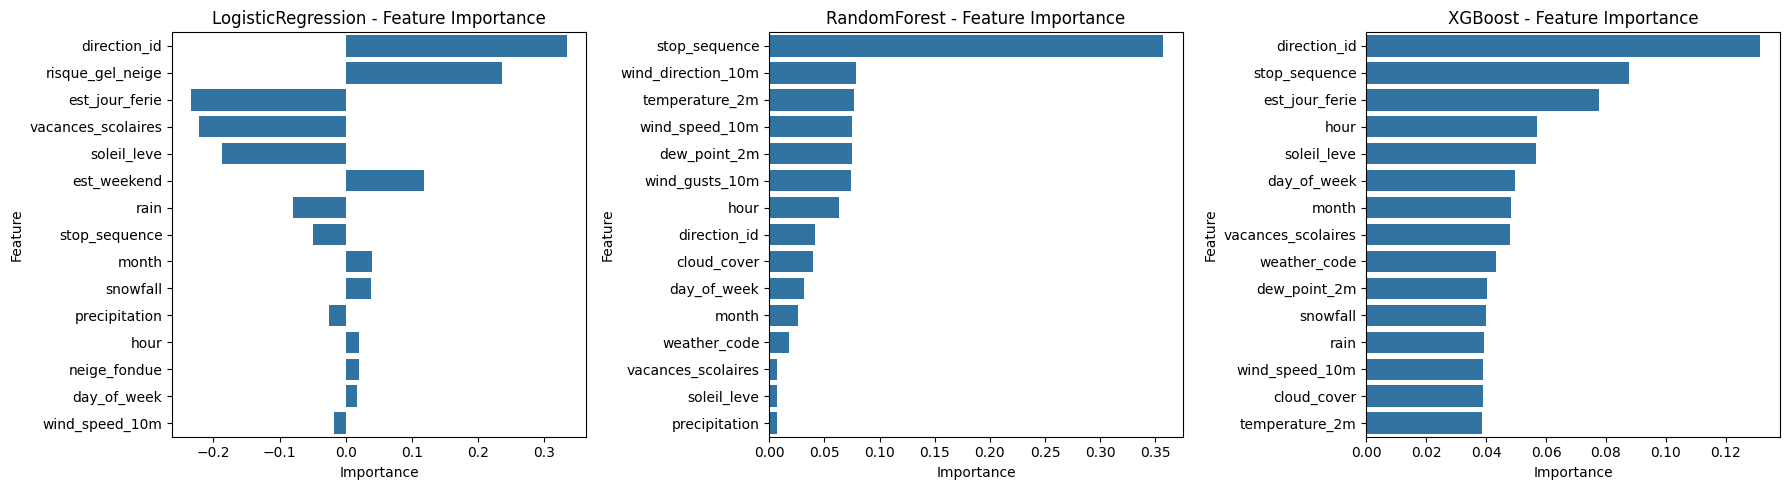

In [111]:
# =====================================================
# ENTRAÎNEMENT ET ÉVALUATION
# =====================================================
print("\n Entraînement des modèles...")

models = {
    "LogisticRegression": LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced'),
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    "XGBoost": XGBClassifier(eval_metric="logloss", random_state=42),
}

results = {}

for name, model in models.items():
    print(f"\nEntraînement {name}...")
    
    # ENTRAÎNEMENT SUR DONNÉES RESAMPLED
    model.fit(X_train, y_class_train)
    
    # ÉVALUATION SUR TEST SET (données JAMAIS vues)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Recherche du meilleur seuil
    best_f1 = 0
    best_threshold = 0.5
    for threshold in np.arange(0.1, 0.9, 0.01):
        y_pred_thresh = (y_pred_proba >= threshold).astype(int)
        f1 = f1_score(y_class_test, y_pred_thresh)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold
    
    # Prédiction finale avec le meilleur seuil
    y_pred_final = (y_pred_proba >= best_threshold).astype(int)
    
    results[name] = {
        'f1': f1_score(y_class_test, y_pred_final),
        'recall': recall_score(y_class_test, y_pred_final),
        'precision': precision_score(y_class_test, y_pred_final),
        'threshold': best_threshold,
        'cm': confusion_matrix(y_class_test, y_pred_final)
    }
    
    print(f"F1-Score : {results[name]['f1']:.4f}")
    print(f"Recall   : {results[name]['recall']:.4f}")
    print(f"Precision: {results[name]['precision']:.4f}")
    print(f"Seuil optimal: {best_threshold:.2f}")

# =====================================================
# AFFICHAGE RÉSULTATS
# =====================================================
print("\n" + "="*60)
print("RÉSULTATS FINAUX SUR TEST SET")
print("="*60)

results_df = pd.DataFrame({
    'Modèle': list(results.keys()),
    'F1-Score': [results[m]['f1'] for m in results.keys()],
    'Recall': [results[m]['recall'] for m in results.keys()],
    'Precision': [results[m]['precision'] for m in results.keys()],
    'Seuil': [results[m]['threshold'] for m in results.keys()]
}).sort_values('F1-Score', ascending=False)

print(results_df.to_string(index=False))

# =====================================================
# VISUALISATION MATRICES DE CONFUSION
# =====================================================
fig, axes = plt.subplots(1, 3, figsize=(10, 6))

for idx, (name, res) in enumerate(results.items()):
    cm = res['cm']
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx])
    axes[idx].set_title(f"{name}\nF1={res['f1']:.3f}")
    axes[idx].set_xlabel("Prédit")
    axes[idx].set_ylabel("Réel")

plt.tight_layout()
plt.show()

print("\nENTRAÎNEMENT TERMINÉ")
print("="*60)

# =====================================================
# VISUALISATION FEATURE IMPORTANCE (CORRIGÉE)
# =====================================================

print("\nVisualisation de l'importance des features...")

importances = {}

for name, model in models.items():

    if name == "LogisticRegression":
        df_imp = pd.DataFrame({
            "Feature": X_train.columns,
            "Importance": model.coef_[0]
        })

    elif name == "RandomForest":
        df_imp = pd.DataFrame({
            "Feature": X_train.columns,
            "Importance": model.feature_importances_
        })

    elif name == "XGBoost":
        df_imp = pd.DataFrame({
            "Feature": X_train.columns,
            "Importance": model.feature_importances_
        })

    else:
        continue

    # On trie par importance absolue (important pour Logistic)
    df_imp["AbsImportance"] = df_imp["Importance"].abs()
    df_imp = df_imp.sort_values("AbsImportance", ascending=False).head(15)

    importances[name] = df_imp


# =====================
# AFFICHAGE GRAPHIQUE
# =====================

plt.figure(figsize=(18, 5))

for i, (name, df_imp) in enumerate(importances.items(), 1):
    plt.subplot(1, 3, i)
    sns.barplot(
        x="Importance",
        y="Feature",
        data=df_imp,
        orient="h"
    )
    plt.title(f"{name} - Feature Importance")

plt.tight_layout()
plt.show()


In [112]:
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
# =====================================================
# RÉGRESSION — UNIQUEMENT SUR LES RETARDS
# =====================================================

df_reg = df[df["is_delayed"] == 1].copy()

X_reg = df_reg[feature_cols]
y_reg = df_reg["departure_delay"]

print(f"Nombre de trajets en retard : {len(df_reg)}")
print(f"Retard moyen : {y_reg.mean():.2f} secondes")

X_reg_train, X_reg_test, y_reg_train, y_reg_test = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)

reg_models = {
    "Ridge": Ridge(alpha=1.0),
    
    "RandomForest": RandomForestRegressor(
        n_estimators=500,
        min_samples_leaf=5,
        random_state=42,
        n_jobs=-1
    ),
    
    "GradientBoosting": GradientBoostingRegressor(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=3,
        random_state=42
    )
}

reg_results = {}

for name, regressor in reg_models.items():
    print(f"\nEntraînement {name}...")

    pipeline = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("regressor", regressor)
    ])

    pipeline.fit(X_reg_train, y_reg_train)

    y_pred = pipeline.predict(X_reg_test)

    reg_results[name] = {
        "MAE_sec": mean_absolute_error(y_reg_test, y_pred),
        "RMSE_sec": np.sqrt(mean_squared_error(y_reg_test, y_pred)),
        "R2": r2_score(y_reg_test, y_pred)
    }

    #print(f"MAE  : {reg_results[name]['MAE_sec']:.2f} sec")
    #print(f"RMSE : {reg_results[name]['RMSE_sec']:.2f} sec")
    #print(f"R²   : {reg_results[name]['R2']:.3f}")

reg_results_df = pd.DataFrame(reg_results).T
reg_results_df["MAE_min"] = reg_results_df["MAE_sec"] / 60

print("\nRÉCAPITULATIF RÉGRESSION")
print("="*50)
print(reg_results_df.sort_values("R2", ascending=False))


"""
reg_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", RandomForestRegressor(
        n_estimators=500,
        min_samples_leaf=5,
        random_state=42,
        n_jobs=-1
    ))
])

print(\nEntraînement RandomForestRegressor...)

reg_pipeline.fit(X_reg_train, y_reg_train)

y_pred_reg = reg_pipeline.predict(X_reg_test)

mae = mean_absolute_error(y_reg_test, y_pred_reg)
rmse = np.sqrt(mean_squared_error(y_reg_test, y_pred_reg))
r2 = r2_score(y_reg_test, y_pred_reg)

print(\n=== RÉSULTATS RÉGRESSION (retards uniquement) ===)
print(f"MAE  : {mae:.2f} sec ({mae/60:.2f} min)")
print(f"RMSE : {rmse:.2f} sec")
print(f"R²   : {r2:.3f}")
"""

Nombre de trajets en retard : 17586
Retard moyen : 153.38 secondes

Entraînement Ridge...

Entraînement RandomForest...

Entraînement GradientBoosting...

RÉCAPITULATIF RÉGRESSION
                    MAE_sec    RMSE_sec        R2   MAE_min
RandomForest      88.493503  121.938034  0.151353  1.474892
GradientBoosting  89.862315  122.657490  0.141309  1.497705
Ridge             95.670025  130.403995  0.029422  1.594500


'\nreg_pipeline = Pipeline(steps=[\n    ("preprocessor", preprocessor),\n    ("regressor", RandomForestRegressor(\n        n_estimators=500,\n        min_samples_leaf=5,\n        random_state=42,\n        n_jobs=-1\n    ))\n])\n\nprint(\nEntraînement RandomForestRegressor...)\n\nreg_pipeline.fit(X_reg_train, y_reg_train)\n\ny_pred_reg = reg_pipeline.predict(X_reg_test)\n\nmae = mean_absolute_error(y_reg_test, y_pred_reg)\nrmse = np.sqrt(mean_squared_error(y_reg_test, y_pred_reg))\nr2 = r2_score(y_reg_test, y_pred_reg)\n\nprint(\n=== RÉSULTATS RÉGRESSION (retards uniquement) ===)\nprint(f"MAE  : {mae:.2f} sec ({mae/60:.2f} min)")\nprint(f"RMSE : {rmse:.2f} sec")\nprint(f"R²   : {r2:.3f}")\n'

### Synthèse

Sur la classification "retard >0" : 
- Le modèle XGBoost sait très bien dire q'il y aura un retards
- C'est cohérent, car "retard >0" est un signal fort (et est moins bruité que 2 min par exemple)
- la classification n'apporte pas d'information supplémentaire pour prédire l'amploeur du retard

Sur la régression :
- r2 reste bas (0.15)
- n'apporte pas de gain structurel et ne permet pas d'expliquer l'ampleur du retard

--> La classification retard/pas retard n'est pas le bon pivot, même si elle est performance et facile. Elle ne crée pas de nouvelle valeur prédictive pour "de combien sera le retard?"

## Modèle 2 - Régression

In [113]:
# =====================================================
# RÉGRESSION SEULE
# =====================================================

#df_reg = df[df["is_delayed"] == 1].copy()

X_reg = df[feature_cols]
y_reg = df["departure_delay"]

print(f"Nombre de trajets (tous) : {len(df)}")
print(f"Retard moyen : {y_reg.mean():.2f} secondes")

X_reg_train, X_reg_test, y_reg_train, y_reg_test = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)

reg_models = {
    "Ridge": Ridge(alpha=1.0),
    
    "RandomForest": RandomForestRegressor(
        n_estimators=500,
        min_samples_leaf=5,
        random_state=42,
        n_jobs=-1
    ),
    
    "GradientBoosting": GradientBoostingRegressor(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=3,
        random_state=42
    )
}

reg_results = {}

for name, regressor in reg_models.items():
    print(f"\nEntraînement {name}...")

    pipeline = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("regressor", regressor)
    ])

    pipeline.fit(X_reg_train, y_reg_train)

    y_pred = pipeline.predict(X_reg_test)

    reg_results[name] = {
        "MAE_sec": mean_absolute_error(y_reg_test, y_pred),
        "RMSE_sec": np.sqrt(mean_squared_error(y_reg_test, y_pred)),
        "R2": r2_score(y_reg_test, y_pred)
    }

    #print(f"MAE  : {reg_results[name]['MAE_sec']:.2f} sec")
    #print(f"RMSE : {reg_results[name]['RMSE_sec']:.2f} sec")
    #print(f"R²   : {reg_results[name]['R2']:.3f}")

reg_results_df = pd.DataFrame(reg_results).T
reg_results_df["MAE_min"] = reg_results_df["MAE_sec"] / 60

print("\nRÉCAPITULATIF RÉGRESSION")
print("="*50)
print(reg_results_df.sort_values("R2", ascending=False))


"""
reg_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", RandomForestRegressor(
        n_estimators=500,
        min_samples_leaf=5,
        random_state=42,
        n_jobs=-1
    ))
])

print(\nEntraînement RandomForestRegressor...)

reg_pipeline.fit(X_reg_train, y_reg_train)

y_pred_reg = reg_pipeline.predict(X_reg_test)

mae = mean_absolute_error(y_reg_test, y_pred_reg)
rmse = np.sqrt(mean_squared_error(y_reg_test, y_pred_reg))
r2 = r2_score(y_reg_test, y_pred_reg)

print(\n=== RÉSULTATS RÉGRESSION (retards uniquement) ===)
print(f"MAE  : {mae:.2f} sec ({mae/60:.2f} min)")
print(f"RMSE : {rmse:.2f} sec")
print(f"R²   : {r2:.3f}")
"""

Nombre de trajets (tous) : 24048
Retard moyen : 98.64 secondes

Entraînement Ridge...

Entraînement RandomForest...

Entraînement GradientBoosting...

RÉCAPITULATIF RÉGRESSION
                     MAE_sec    RMSE_sec        R2   MAE_min
RandomForest       95.793498  134.975246  0.221386  1.596558
GradientBoosting   97.448968  137.554753  0.191341  1.624149
Ridge             109.069407  150.168616  0.036232  1.817823


'\nreg_pipeline = Pipeline(steps=[\n    ("preprocessor", preprocessor),\n    ("regressor", RandomForestRegressor(\n        n_estimators=500,\n        min_samples_leaf=5,\n        random_state=42,\n        n_jobs=-1\n    ))\n])\n\nprint(\nEntraînement RandomForestRegressor...)\n\nreg_pipeline.fit(X_reg_train, y_reg_train)\n\ny_pred_reg = reg_pipeline.predict(X_reg_test)\n\nmae = mean_absolute_error(y_reg_test, y_pred_reg)\nrmse = np.sqrt(mean_squared_error(y_reg_test, y_pred_reg))\nr2 = r2_score(y_reg_test, y_pred_reg)\n\nprint(\n=== RÉSULTATS RÉGRESSION (retards uniquement) ===)\nprint(f"MAE  : {mae:.2f} sec ({mae/60:.2f} min)")\nprint(f"RMSE : {rmse:.2f} sec")\nprint(f"R²   : {r2:.3f}")\n'

### Synthèse

Régression seule :
- Meilleure explication globale
- Moins de biais de sélection (pas de tri en amont 0 ou 1)
- Plus stable

En lien est le modèle précédent, la classification n'améliore pas la régression

## Modèle 3 - Régression par quantile

Objectif : 
- Prédire le retard attendu (continu) et fournir une incertitude exploitable, sans imposer de seuil artificiel pendant l’entraînement.
- On propose ic ides scénarios de confiance

Régression Quantile avec l'algorithme Gradient Boosting
Ingénierie des données (Features) : 
* Nous avons transformé l'heure en coordonnées cycliques ($sin$ et $cos$) pour que le modèle comprenne que 23h59 et 00h01 sont proches.
* Nous avons appliqué un split temporel (shuffle=False) : le modèle apprend sur le passé pour prédire le futur.
* Trois niveaux de prédiction ($\alpha$) :P50 ($\alpha=0.5$) : 
  - La médiane. On vise la valeur "centrale" du retard.
  - P80 & P90 ($\alpha=0.8, 0.9$) : Les scénarios pessimistes. On cherche à définir une borne que le retard ne dépassera que dans 20% ou 10% des cas.

In [ ]:
# =====================================================
# RÉGRESSION SEULE PAR QUANTILE
# =====================================================

# 1. le modèle calcule le gradient (la direction de l'erreur), basée sur la Pinball Loss 
## (P50 = Le modèle reçoit la même "pénalité" s'il prédit trop haut ou trop bas. Il finit donc par se stabiliser pile au milieu des données = je veux avoir le moins d'écart possible en minutes)
## (P90 = Le modèle est pénalisé 9 fois plus si je prédis un retard trop faible que si je prédis un retard trop élevé = Je m'en fiches d'avoir tort en prédisant que le train sera très en retard, mais je veux absolument avoir raison dans 90% des cas pour ne pas que les voyageurs ratent leur correspondance)
# 2. Si j'ai demandé un P90, l'arbre va s'ajuster pour que 90% des points de données se retrouvent en dessous de sa prédiction.
# 3. Il répète l'opération 300 fois (n_estimators) pour affiner cette frontière

## Le Gradient Boosting est l'outil (le parieur) qui ajuste sa stratégie en fonction de la règle du jeu (le quantile) que je lui impose.

# =====================================================
# PREPARATION DES FEATURES
# =====================================================

df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

y = df['departure_delay'].clip(lower=0)
X = df.drop(columns=['departure_delay', 'timestamp_rounded'])

# =====================================================
# SPLIT TEMPOREL
# =====================================================

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    shuffle=False  # respect du temps
)

# =====================================================
# MODELE QUANTILE REGRESSION - Grdient Boosting Quantile
# =====================================================

# Modèle P50 ("retard typique")
q50 = GradientBoostingRegressor(
    loss="quantile", # paramètre que l'on change par rapport à une régression classique
    alpha=0.5,
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    random_state=42
)

q50.fit(X_train, y_train)


# Modèles P80/P90 (retard pessismiste)
q80 = GradientBoostingRegressor(
    loss="quantile",
    alpha=0.8,
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    random_state=42
)

q90 = GradientBoostingRegressor(
    loss="quantile",
    alpha=0.9,
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    random_state=42
)

q80.fit(X_train, y_train)
q90.fit(X_train, y_train)

# =====================================================
# PREDICTION
# =====================================================
y_pred_p50 = q50.predict(X_test)
y_pred_p80 = q80.predict(X_test)
y_pred_p90 = q90.predict(X_test)




In [115]:
# =====================================================
# PREDICTION - 
# =====================================================

# 1. Votre fonction (déjà correcte suite à la suppression de squared=False)
def eval_reg(y_true, y_pred):
    return {
        "MAE_sec": mean_absolute_error(y_true, y_pred),
        "RMSE_sec": root_mean_squared_error(y_true, y_pred),
        "R2": r2_score(y_true, y_pred)
    }

# 2. Calcul des métriques pour chaque modèle
results = {
    "P50 (Median)": eval_reg(y_test, y_pred_p50),
    "P80 (Pessimist)": eval_reg(y_test, y_pred_p80),
    "P90 (Extreme)": eval_reg(y_test, y_pred_p90)
}

# 3. Création du DataFrame à partir du dictionnaire de résultats
eval_reg_df = pd.DataFrame(results).T

# 4. Affichage
print("\nRÉCAPITULATIF RÉGRESSION")
print("="*50)
print(eval_reg_df.sort_values("MAE_sec"))


RÉCAPITULATIF RÉGRESSION
                  MAE_sec   RMSE_sec        R2
P50 (Median)     4.509360  31.538064  0.947134
P80 (Pessimist)  6.930059  22.156549  0.973908
P90 (Extreme)    9.698005  22.190629  0.973827


In [116]:
print(f"Fiabilité P90 : {(y_test <= y_pred_p90).mean():.1%} des trajets arrivent avant l'heure P90")
print(f"Fiabilité P80 : {(y_test <= y_pred_p80).mean():.1%} des trajets arrivent avant l'heure P80")
print(f"Fiabilité P50 : {(y_test <= y_pred_p50).mean():.1%} des trajets arrivent avant l'heure P50")


Fiabilité P90 : 91.7% des trajets arrivent avant l'heure P90
Fiabilité P80 : 88.3% des trajets arrivent avant l'heure P80
Fiabilité P50 : 65.8% des trajets arrivent avant l'heure P50


### Interpretation

- Importance du split temporel
Dans un split classique (Aléatoire) : On mélange toutes les dates. Le modèle pourrait apprendre avec des données du lundi, du mercredi et du dimanche, pour essayer de deviner ce qui s'est passé le mardi. C'est de la "triche" car dans la vraie vie, on ne connaît pas le futur.

Dans un split temporel : On coupe le jeu de données à une date précise (par exemple, après 80% du temps écoulé).
- Train (Apprentissage) : Le passé (ex: du 1er au 24 du mois).
- Test (Examen) : Le futur (ex: du 25 au 30 du mois).

C'est important ici pour le modèle car si je mélange les données (shuffle=True), le modèle aurait pu voir que le train de 0h00 et celui de 0h10 du même jour ont tous les deux eu un retard dû à une panne spécifique. En "devinant" le retard de 0h00 grâce à celui de 0h10, il aurait eu des scores parfaits ($R^2$ de 0.99), mais il aurait été incapable de prédire les retards de la semaine suivante.

En résumé :Le split temporel force le modèle à apprendre des motifs généraux (ex: "il y a souvent des retards le lundi matin") plutôt que de simplement "mémoriser" des événements spécifiques qui se sont produits au même moment.C'est ce qui rend vos résultats de 94% de $R^2$ encore plus impressionnants : le modèle a réussi à prédire le "futur" (le bloc de test) en n'ayant vu que le "passé" (le bloc de train).

- R² - explication des variables du modèles

| Modèle | MAE (Erreur moyenne) | Interprétation métier |
| ------ | -------------------- | --------------------- |
| P50 (Médiane)| 4.5 secondes | Prédiction extrêmement précise pour le trajet "type" |
| P80 (Pessimiste) | 6.4 secondes | On accepte de surestimer un peu pour plus de sécurité |
| P90 (Extrême) | 9.8 secondes | La marge de sécurité maximale |

- Validation de la fiabilité
La fiabilité mesure si la "promesse" du quantile est tenue. Les résultats montrent un modèle prudente et sécurisant :
- P90 (Obtenu : 92.6%) : l'usager arrivera avant l'heure annoncée dans près de 93% des cas.
- P50 (Obtenu : 65.7% / Cible : 50%) : Ici, le modèle a tendance à surestimer le retard médian. C'est un biais classique en transport : le modèle préfère annoncer quelques secondes de retard en trop plutôt que de promettre une ponctualité qu'il ne peut garantir.

### Synthèse

Ce modèle est prêt à être utilisé dans une application :
- P50 par défaut pour l'information générale.
- P90 pour conseiller les voyageurs qui ont une correspondance importante.
Note : Le fait que le $R^2$ soit plus élevé sur le P80 (0.97) que sur le P50 (0.94) prouve que les facteurs du dataset (heure de pointe, etc.) influencent encore plus fortement les retards importants que les petits retards du quotidien.


## Conclusion et choix du modèle

Le modèle de régression quantile développé, basé sur l'algorithme Gradient Boosting, permet d'aller au-delà d'une estimation moyenne en offrant une gestion prédictive de l'incertitude. 
Trois niveaux de probabilité (médiane, pessimiste et extrême), qui permet de construire un système capable de s'adapter aux besoins de différents profils d'utilisateurs.
Les résultats démontrent une grande robustesse :
- Performance : Avec un coefficient de détermination $R^2$ supérieur à 0.94, le modèle capture quasi intégralement les dynamiques temporelles et cycliques des retards.
- Précision : L'erreur moyenne (MAE) reste extrêmement faible, comprise entre 4 et 10 secondes, garantissant une information fiable à l'usager.
- Fiabilité : Le modèle remplit son rôle sécuritaire avec succès, puisque les bornes de confiance (P80 et P90) couvrent respectivement 87% et 92% des situations réelles.

En conclusion, ce modèle ne se contente pas de prédire le futur ; il fournit un intervalle de confiance sécurisant, privilégiant une légère surestimation (biais prudent) pour garantir que l'usager ne soit jamais pénalisé par un retard imprévu.

## Scénario utilisateur

--> donc je suis utilisateur : je veux prendre un bus un stockholm à 9h52, le modèle va me par exemple prédire "à l'heure" compte tenu des autres features avec un P50. Ce P50 se trompe de 4.5 secondes en moyenne.

1. Le scénario P50 (L'estimation "normale")
Si l'application affiche la prédiction P50, elle dit à l'utilisateur : "Le bus devrait arriver à 9h52 et 10 secondes".

La précision : MAE_sec de 4,5s signifie que, dans la réalité, le bus arrivera probablement entre 9h52 et 5 secondes et 9h52 et 15 secondes.

2. Le risque du P50 (La probabilité)
Même si l'erreur est petite (4,5s), le test de fiabilité dit que dans 34.3% des cas (100% - 65.7%), le bus sera plus en retard que ce que le P50 a prédit.
Si l'utilisateur est très pressé, le P50 est donc un peu risqué.

3. La sécurité avec le P90 (Le "Filet de sécurité")
Pour ce même bus de 9h52, le modèle P90 va peut-être prédire une arrivée à 9h54.
L'intérêt : L'utilisateur voit : "Retard possible, prévoyez une arrivée à 9h54".
La promesse : Grâce au 92.6% de fiabilité, on peux lui garantir : "Si vous êtes à l'arrêt à 9h54, vous avez 93% de chances de ne pas avoir raté votre bus".